# Water Quality Portal

In [23]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import contextily as ctx
from shapely.geometry import Point
from shapely import wkt
from geopandas.tools import sjoin

In [9]:
# load data that comes form Water Quality Portal
path = "/Users/Administrator/Documents/University/Year 3/2b/Thesis/data/Water quality portal/location/locations.xlsx"
excel_data = pd.ExcelFile(path)

excel_data.sheet_names #sheet names

['versie_WKP_2.0', 'titels']

In [11]:
df = pd.read_excel(path, sheet_name="versie_WKP_2.0")
df = df[df["provincie"] == "Provincie Flevoland"] #we are interested only in Flevolance Province

    NITGnummer + filter       X       Y  \
689        B15H0025_001  171500  530500   
690        B15H0025_002  171500  530500   
691        B15H0031_001  179430  535300   
692        B15H0031_002  179430  535300   
693        B15H0031_004  179430  535300   

    bovenkant filterdiepte meter t.o.v. maaiveld  \
689                                       -14.72   
690                                       -50.43   
691                                          -12   
692                                          -22   
693                                         -186   

    onderkant filterdiepte meter t.o.v. maaiveld\n  \
689                                         -15.72   
690                                         -51.43   
691                                            -14   
692                                            -24   
693                                           -188   

    bovekant filterdiepte meter t.o.v. NAP            provincie  \
689                                 

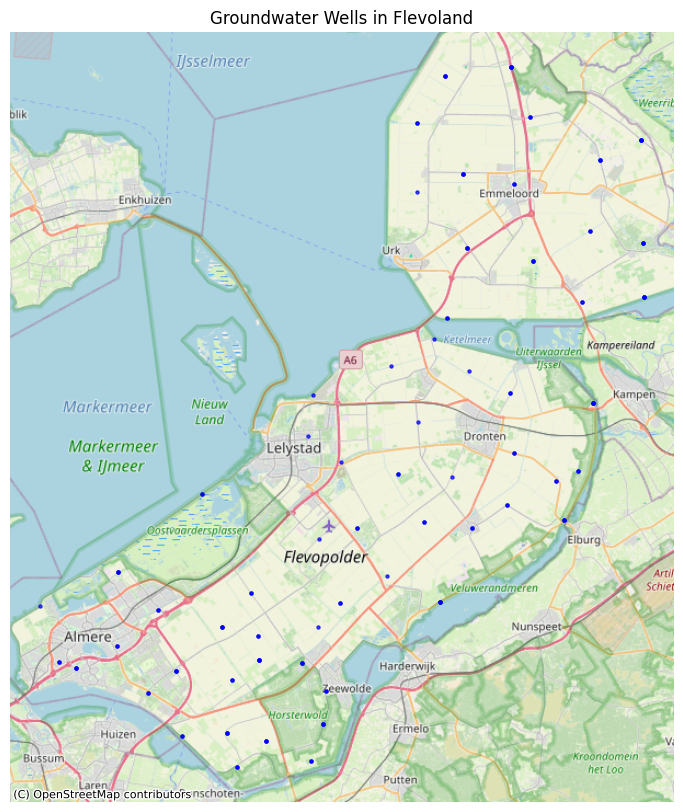

In [15]:
geometry = [Point(xy) for xy in zip(df["X"], df["Y"])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:28992")  # convert X and Y coordinates into geo format POINT()

#Web Mercato
gdf = gdf.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color="blue", markersize=5, alpha=0.7)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik) #adding NL map as a background to understand location of points
ax.set_title("Groundwater Wells in Flevoland")
ax.axis("off")
plt.show()

In [19]:
#convert to WGS84 (lat/lon)
gdf_wgs84 = gdf.to_crs("EPSG:4326")

gdf_wgs84["lon"] = gdf_wgs84.geometry.x  #adding lat/lon columns
gdf_wgs84["lat"] = gdf_wgs84.geometry.y

gdf_wgs84["geometry_wkt"] = gdf_wgs84.geometry.apply(lambda geom: geom.wkt)

print(gdf_wgs84.head())

    NITGnummer + filter       X       Y  \
689        B15H0025_001  171500  530500   
690        B15H0025_002  171500  530500   
691        B15H0031_001  179430  535300   
692        B15H0031_002  179430  535300   
693        B15H0031_004  179430  535300   

    bovenkant filterdiepte meter t.o.v. maaiveld  \
689                                       -14.72   
690                                       -50.43   
691                                          -12   
692                                          -22   
693                                         -186   

    onderkant filterdiepte meter t.o.v. maaiveld\n  \
689                                         -15.72   
690                                         -51.43   
691                                            -14   
692                                            -24   
693                                           -188   

    bovekant filterdiepte meter t.o.v. NAP            provincie  \
689                                 

In [20]:
print(len(gdf_wgs84))

138


In [21]:
# now we want to compare two datasets with nitrate values, to see if one can complete the other one
compare_file_path = "/Users/Administrator/Documents/University/Year 3/2b/Thesis/Bachelor-Thesis/data/raw/well_chem_data/flevoland_well_combined.csv"

compare_df = pd.read_csv(compare_file_path)

In [24]:
#convert the 'geometry' column from WKT to shapely Point objects
compare_df["geometry"] = compare_df["geometry"].apply(wkt.loads)

compare_gdf = gpd.GeoDataFrame(compare_df, geometry="geometry", crs="EPSG:4326") #create a GeoDataFrame

# Check how many points in gdf_wgs84 are also in compare_gdf
# We'll use the 'geometry' column from both and find exact matches
matching_points = gdf_wgs84["geometry"].isin(compare_gdf["geometry"])

match_count = matching_points.sum()
total_points = len(gdf_wgs84)

match_count, total_points

(0, 138)

In [27]:
# round to 5 decimal places so we can compare
gdf_wgs84["lon_round"] = gdf_wgs84["lon"].round(5)
gdf_wgs84["lat_round"] = gdf_wgs84["lat"].round(5)

compare_gdf["lon_round"] = compare_gdf.geometry.x.round(5)
compare_gdf["lat_round"] = compare_gdf.geometry.y.round(5)

gdf_unique = gdf_wgs84.drop_duplicates(subset=["lon_round", "lat_round"]) # drop duplicates based on rounded coordinates
compare_unique = compare_gdf.drop_duplicates(subset=["lon_round", "lat_round"])

#merge on rounded coordinates to find matching locations
merged = pd.merge(
    gdf_unique,
    compare_unique,
    on=["lon_round", "lat_round"],
    how="inner"
)

match_count = len(merged)
total_gdf = len(gdf_unique)
total_compare = len(compare_unique)

match_count, total_gdf, total_compare


(48, 62, 183)

In [38]:
print("Matched coordinate points (rounded):")
print(merged[["lon_round", "lat_round"]].drop_duplicates())

Matched coordinate points (rounded):
    lon_round  lat_round
0     5.63164   52.76157
1     5.66669   52.79771
2     5.68871   52.72360
3     5.75274   52.71588
4     5.77213   52.76641
5     5.86023   52.73392
6     5.66832   52.61392
7     5.69379   52.66697
8     5.53640   52.50434
9     5.60734   52.49515
10    5.59816   52.57740
11    5.50074   52.55507
12    5.74817   52.55637
13    5.75207   52.51079
14    5.63186   52.53465
15    5.69624   52.57314
16    5.65194   52.59793
17    5.67456   52.49272
18    5.77634   52.65747
19    5.84811   52.67996
20    5.83765   52.62607
21    5.91425   52.67083
22    5.91523   52.62944
23    5.83302   52.49694
24    5.80490   52.48923
25    5.30641   52.39107
26    5.25637   52.42024
27    5.42321   52.40386
28    5.38720   52.37762
29    5.36189   52.47944
30    5.25507   52.36317
31    5.29332   52.32770
32    5.20303   52.34647
33    5.18246   52.35138
34    5.33590   52.29447
35    5.32851   52.34390
36    5.43344   52.35289
37    5.39894

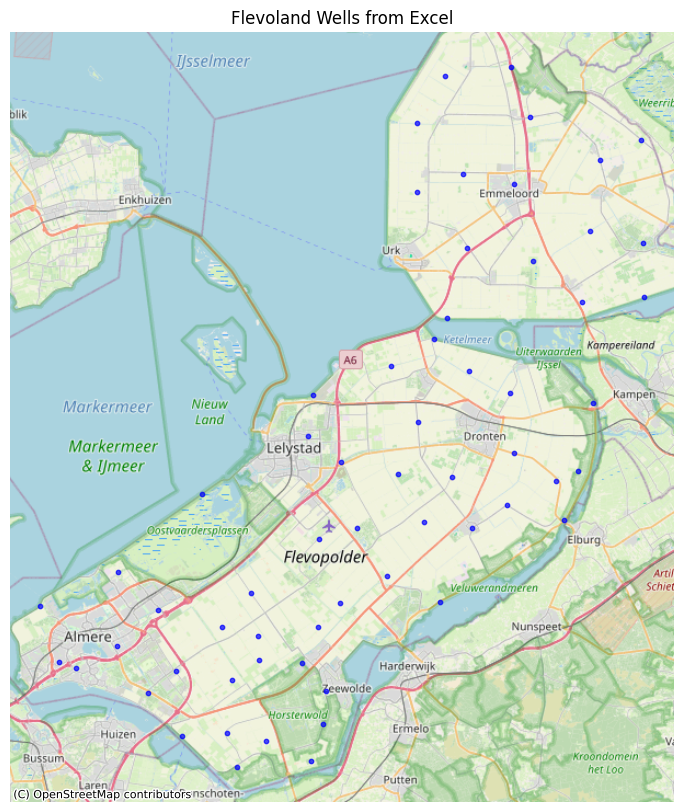

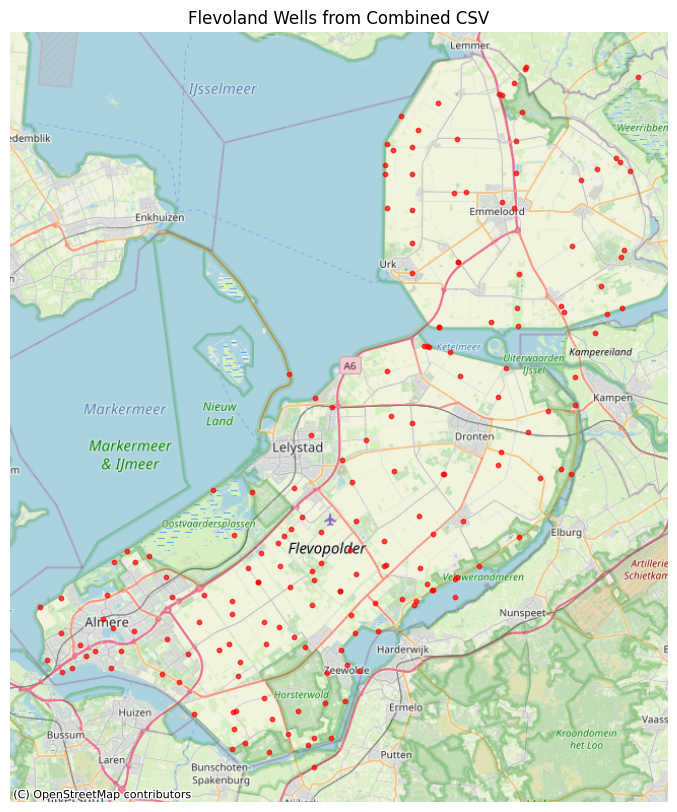

In [31]:
#Below we display both datasets on the map
# convert both GeoDataFrames to Web Mercator for basemap compatibility
gdf_unique_web = gdf_unique.set_geometry(gdf_unique.geometry).to_crs(epsg=3857)
compare_unique_web = compare_unique.set_geometry(compare_unique.geometry).to_crs(epsg=3857)

# Flevoland wells (from Excel)
fig1, ax1 = plt.subplots(figsize=(10, 10))
gdf_unique_web.plot(ax=ax1, color='blue', markersize=10, alpha=0.7)
ctx.add_basemap(ax1, source=ctx.providers.OpenStreetMap.Mapnik)
ax1.set_title("Flevoland Wells from Excel")
ax1.axis("off")

# Combined wells (from CSV)
fig2, ax2 = plt.subplots(figsize=(10, 10))
compare_unique_web.plot(ax=ax2, color='red', markersize=10, alpha=0.7)
ctx.add_basemap(ax2, source=ctx.providers.OpenStreetMap.Mapnik)
ax2.set_title("Flevoland Wells from Combined CSV")
ax2.axis("off")

plt.show()

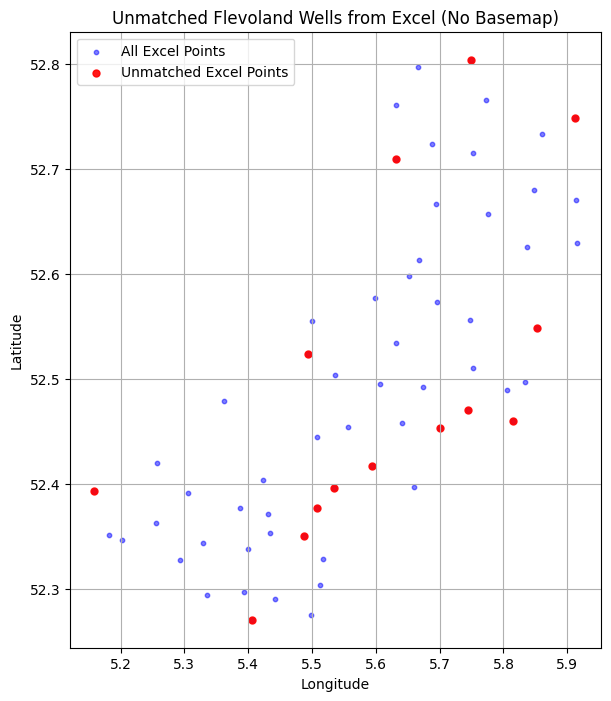

In [32]:
# display the intersection between two datasets
merged_coords = merged[["lon_round", "lat_round"]]
unmatched_gdf = gdf_unique.merge(merged_coords, on=["lon_round", "lat_round"], how="left", indicator=True)
unmatched_gdf = unmatched_gdf[unmatched_gdf["_merge"] == "left_only"]

fig, ax = plt.subplots(figsize=(8, 8))
gdf_unique.plot(ax=ax, color='blue', markersize=10, alpha=0.5, label="All Excel Points")
unmatched_gdf.plot(ax=ax, color='red', markersize=25, alpha=0.9, label="Unmatched Excel Points")
ax.set_title("Unmatched Flevoland Wells from Excel (No Basemap)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(True)
ax.legend()

plt.show()

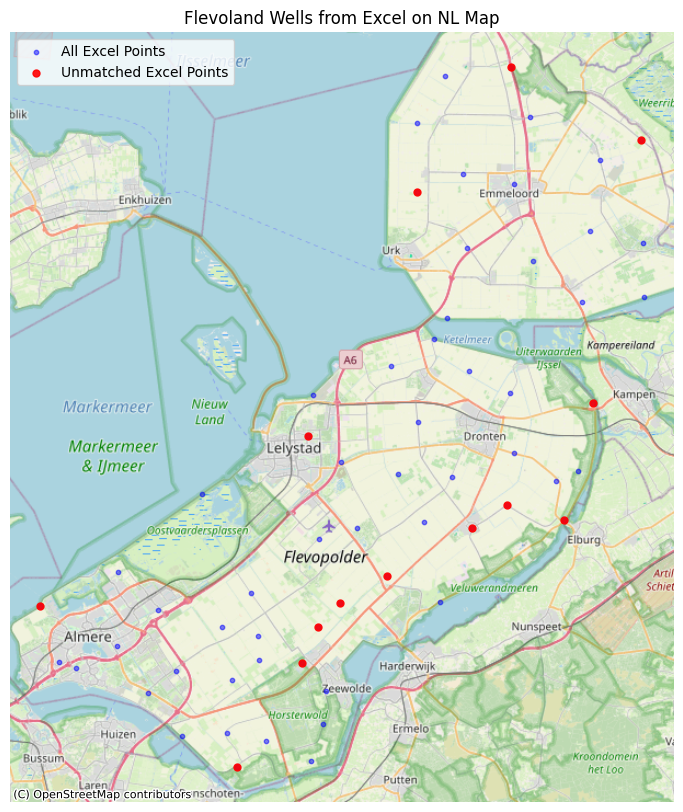

In [34]:
gdf_unique_web = gdf_unique.to_crs(epsg=3857)
unmatched_gdf_web = unmatched_gdf.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 10))
gdf_unique_web.plot(ax=ax, color='blue', markersize=10, alpha=0.5, label='All Excel Points')
unmatched_gdf_web.plot(ax=ax, color='red', markersize=25, alpha=0.9, label='Unmatched Excel Points')

# OpenStreetMap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_title("Flevoland Wells from Excel on NL Map")
ax.axis("off")
ax.legend()
plt.show()